In [111]:
from pathlib import Path

import pandas as pd
import numpy as np

from tensorflow.keras.layers import Dense, Input, Lambda, Conv2D, MaxPooling2D, Flatten, Dropout, LSTM
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, Adadelta
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelBinarizer

from imblearn.combine import SMOTETomek

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline  
plt.rcParams['figure.figsize'] = (20,10)

In [112]:
DATA_DIR = Path("../../data/public/football-data/data")

In [113]:
df = pd.DataFrame()
subjects = ["Subject-000", "Subject-001", "Subject-002", 
            "Subject-003", "Subject-004", "Subject-005",
            "Subject-006", "Subject-007", "Subject-008"]
for s in subjects:
    for d in DATA_DIR.joinpath(s).iterdir():
        current_df = pd.read_csv(str(d))
        y = d.stem.split("-")[0]
        current_df["y"] = y
        if y == "Pass" and np.random.random() > .7:
            df = df.append(current_df[::5])
        elif y == "Dribbling" and np.random.random() > .3:
            df = df.append(current_df[::5])
        elif y == "Walking" or y == "Running":
            current_df["y"] = "Around"
            df = df.append(current_df[::5])
        elif y != "Pass" and y != "Dribbling":
            df = df.append(current_df[::5])

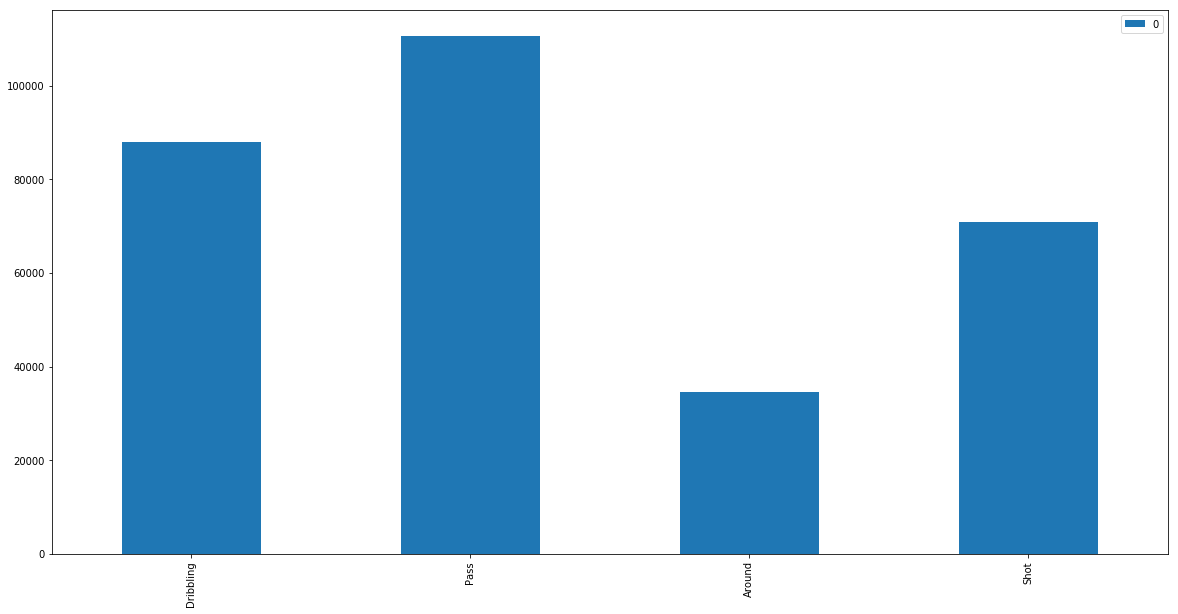

In [114]:
from collections import Counter
letter_counts = Counter(df.y.values)
dft = pd.DataFrame.from_dict(letter_counts, orient="index")
dft.plot(kind="bar")

In [115]:
X = df.drop("y", axis=1).values
y = df.y.values

In [87]:
# sm = SMOTETomek(random_state=42)
# X, y = sm.fit_resample(X, y)

In [88]:
X.shape, y.shape

((300984, 12), (300984,))

## Siamese NN

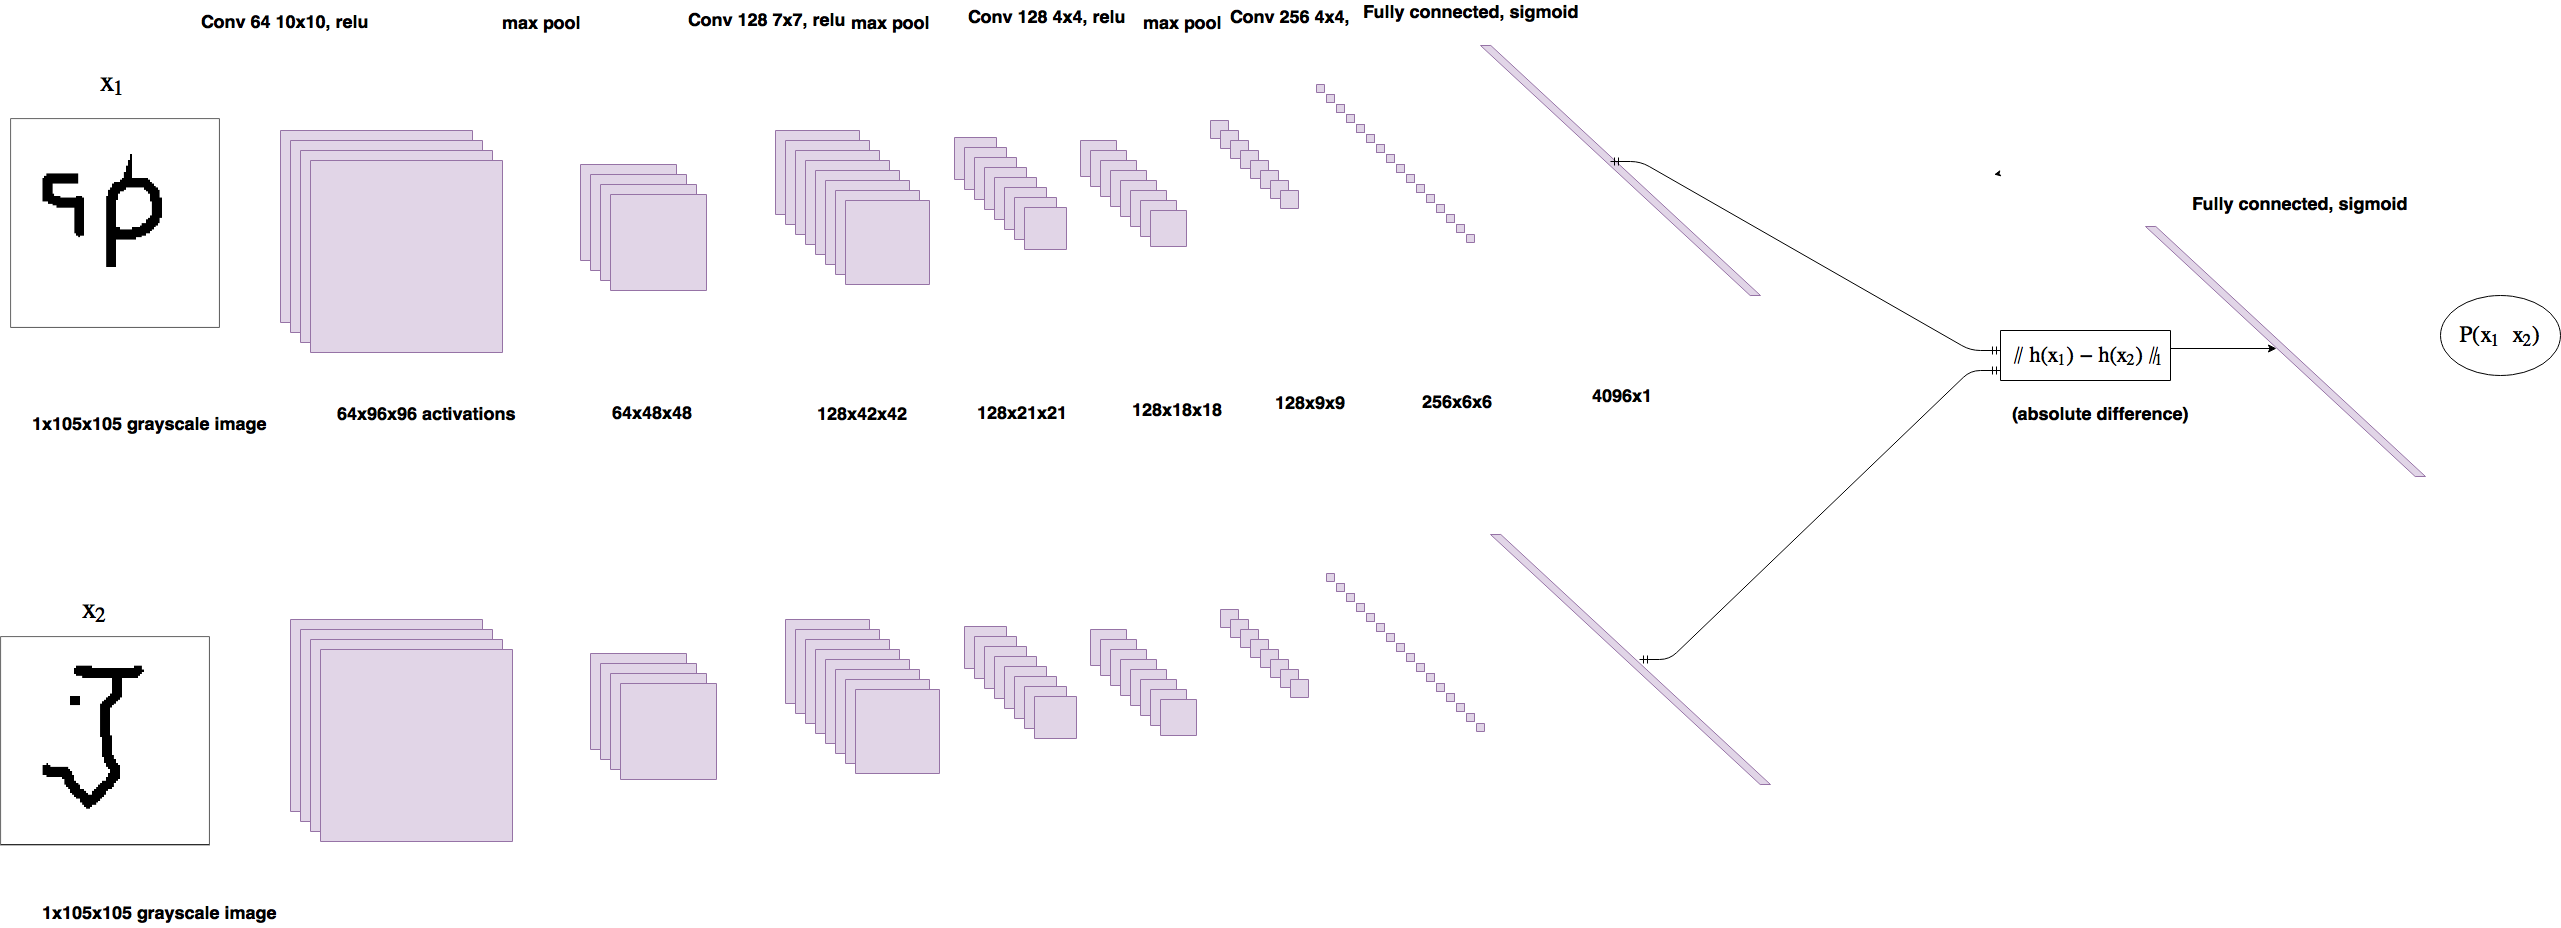

In [116]:
def df_to_X_y_seq(df, seq_len):
    X = []
    y = []

    for start, end in zip(np.arange(0, df.shape[0] - seq_len, seq_len), np.arange(seq_len, df.shape[0], seq_len)):
        X.append(df.iloc[start:end,:-1].values)
        y.append(df.iloc[start:end,-1].mode()[0])
        
    X = np.array(X)
    y = np.array(y)
    return X, y

In [117]:
X, y = df_to_X_y_seq(df, 800)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [118]:
input_shape = (800, 12, 1)
left_input = Input(input_shape)
right_input = Input(input_shape)

In [119]:
convnet = Sequential()
convnet.add(Conv2D(64,(100, 3), strides=(1,1), activation='relu', input_shape=input_shape, kernel_regularizer=l2(2e-4)))
convnet.add(MaxPooling2D())

convnet.add(Conv2D(128,(50, 2),activation='relu', kernel_regularizer=l2(2e-4)))
convnet.add(MaxPooling2D())

convnet.add(Conv2D(128,(20,1),activation='relu', kernel_regularizer=l2(2e-4)))
convnet.add(MaxPooling2D())

convnet.add(Conv2D(64,(4,1),activation='relu', kernel_regularizer=l2(2e-4)))
convnet.add(Flatten())

convnet.add(Dense(4096, activation="sigmoid",kernel_regularizer=l2(1e-3)))

In [107]:
convnet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 701, 10, 64)       19264     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 350, 5, 64)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 301, 4, 128)       819328    
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 150, 2, 128)       0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 131, 2, 128)       327808    
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 65, 1, 128)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 62, 1, 64)         32832     
__________

In [120]:
encoded_l = convnet(left_input)
encoded_r = convnet(right_input)

L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
L1_distance = L1_layer([encoded_l, encoded_r])
    
prediction = Dense(1, activation='sigmoid')(L1_distance)
siamese_net = Model(inputs=[left_input, right_input], outputs=prediction)

siamese_net.compile(loss="binary_crossentropy", optimizer=Adam(0.00006))

In [102]:
siamese_net.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 800, 12, 1)   0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           (None, 800, 12, 1)   0                                            
__________________________________________________________________________________________________
sequential_9 (Sequential)       (None, 1024)         5263488     input_19[0][0]                   
                                                                 input_20[0][0]                   
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 1024)         0           sequential_9[1][0]               
          

In [121]:
class SiameseLoader:
    """For loading batches and testing tasks to a siamese net"""
    def __init__(self, data, categories):
        self.data = data
        self.categories = categories
        self.info = {}
        
    def get_batch(self, batch_size, s="train"):
        """
        Create batch of n pairs, half same class, half different class
        
        Parameters
        ----------
        batch_size: int
            Number of pairs to create

        s: str
            Set name

        Returns
        -------
        tuple
            tuple[0] -> array like of shape (batch_size, 2, window_size, n_features, 1) containing the pairs of the batch
            tuple[1] -> array like of shape (batch_size) containing the targets. 
        """
        X = self.data[s]
        y = self.categories[s]
        
        n_seq, seq_length, n_features = X.shape

        # Initialize 2 empty arrays for the input image batch
        pairs = [np.zeros((batch_size, seq_length, n_features, 1)) for i in range(2)]
        
        # Initialize vector for the targets, and make one half of it '1's, so 2nd half of batch has same class
        targets = np.zeros((batch_size,))
        targets[batch_size//2:] = 1
        labels = []
        for i in range(batch_size):
            idx_1 = np.random.randint(0, n_seq)
            pairs[0][i,:,:,:] = X[idx_1].reshape(seq_length, n_features, 1)
            pair_0_label = y[idx_1]
                        
            # Pick images of same class for 1st half, different for 2nd
            if i >= batch_size // 2:
                idx_2 = np.random.choice([l[0] for l in enumerate(y) if l[1] == pair_0_label])
            else: 
                idx_2 = np.random.choice([l[0] for l in enumerate(y) if l[1] != pair_0_label])
            
            labels.append((pair_0_label, y[idx_2]))
            
            pairs[1][i,:,:,:] = X[idx_2].reshape(seq_length, n_features, 1)
            
        return pairs, targets, labels
    
    def generate(self, batch_size, s="train"):
        """A generator for batches, so model.fit_generator can be used. """
        while True:
            pairs, targets = self.get_batch(batch_size, s)
            yield (pairs, targets)    
            
    def make_oneshot_task(self, s="val", N=5):
        """
        Create pairs of test image, support set for testing N way one-shot learning. 
        
        Parametes
        ---------
        s: str, optional
            Name of the used set
        N: int, optional
            Support set size

        Returns
        -------
        tuple
            tuple[0] -> array like of shape (batch_size, 2, window_size, n_features, 1) containing the pairs of the batch
                        Paris where first element is the test image and the second one is an instance of the support set
            tuple[1] -> array like of shape (batch_size) with a single 1, which is the target of support set
        """
        X = self.data[s]
        y = self.categories[s]
        enum_labels = list(enumerate(y))

        n_seq, seq_length, n_features = X.shape
    
        # Pick the true label
        true_label = np.random.choice(y)
        true_instances = np.array([l[0] for l in enum_labels if l[1] == true_label]).astype(np.int)
        false_instances = np.array([l[0] for l in enum_labels if l[1] != true_label]).astype(np.int)

        # Build the support set
        support_set_idx = np.random.choice(false_instances, size=(N))        
        support_set = X[support_set_idx].reshape(N, seq_length, n_features, 1)
        if len(true_instances) == 1:
            test_img_idx, support_true_idx = true_instances[0], true_instances[0]
        else:
            test_img_idx, support_true_idx = np.random.choice(true_instances, size=(2,), replace=False)
        support_set[0,:,:,:] = X[support_true_idx].reshape(seq_length, n_features, 1)
        
        # Pick the same test image N times
        test_img = [X[test_img_idx].reshape(seq_length, n_features, 1)]*N
        
        # Set the first target to 1 because the first element of support set is the desired output
        targets = np.zeros((N,))
        targets[0] = 1
        
        targets, test_img, support_set = shuffle(targets, test_img, support_set)
        pairs = [test_img, support_set]
        
        return pairs, targets
    
    def test_oneshot(self, model, k, s="val", verbose=0):
        """
        Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks
        
        Parameters
        ----------
        model: kearas.model
        
        k: int
            Number of one shot tasks
        s: str, optional
            Name of the set
        verbose: boolean, optional
            If True -> print the accuracy
        
        Returns
        -------
        float
            Accuaracy on the k one shot tasks
        """
        n_correct = 0
        for i in range(k):
            inputs, targets = self.make_oneshot_task(s)
            probs = model.predict(inputs)
            if np.argmax(probs) == np.argmax(targets):
                n_correct += 1
        percent_correct = (100.0 * n_correct / k)
        if verbose:
            print("Got an average of {}% learning accuracy".format(percent_correct))
        return percent_correct
    
loader = SiameseLoader(data={"train": X, "val": X_val}, categories={"train": y, "val": y_val})       

In [ ]:
n_iter = 10000
loss_every = 10
weights_path = "siamese_net.h5"
batch_size = 30

best_loss = 99999
for i in range(1, n_iter):
    (inputs, targets, l) = loader.get_batch(batch_size)
    loss = siamese_net.train_on_batch(inputs, targets)
    
    if i % loss_every == 0:
        print("Iteration {}, Loss: {}".format(i, loss))
        val_acc = loader.test_oneshot(siamese_net, 20, verbose=True)
        
        # If loss improve store the weights
        if best_loss > loss:
            best_loss = loss
            siamese_net.save(weights_path)

Iteration 10, Loss: 4.738343715667725
Got an average of 10.0% learning accuracy
Iteration 20, Loss: 4.528273582458496
Got an average of 20.0% learning accuracy
Iteration 30, Loss: 4.491596221923828
Got an average of 30.0% learning accuracy
Iteration 40, Loss: 4.445683002471924
Got an average of 20.0% learning accuracy
Iteration 50, Loss: 4.259075164794922
Got an average of 20.0% learning accuracy
Iteration 60, Loss: 4.250630855560303
Got an average of 15.0% learning accuracy
Iteration 70, Loss: 4.09628438949585
Got an average of 25.0% learning accuracy
Iteration 80, Loss: 4.063808441162109
Got an average of 20.0% learning accuracy
Iteration 90, Loss: 3.969298839569092
Got an average of 25.0% learning accuracy
Iteration 100, Loss: 3.883070230484009
Got an average of 10.0% learning accuracy


## Making predictions

In [18]:
all_X = np.concatenate((X, X_val))
examples, seq_len, features = all_X.shape
all_X = all_X[:].reshape(examples, seq_len, features, 1)
all_y = np.concatenate((y, y_val))

np.savez("prediction_set.npz", y=all_y, X=all_X)

In [19]:
def predict(model, serie, prediction_set):
    """
    Parameters
    ----------
    model: keras.model
    
    serie: array of shape (200, 7)
    
    Returns
    -------
    tuple
        tuple[0] -> label of the `serie`
        tuple[1] -> max probability of each class
    """
    
    # Pair the serie with each instance in the prdiction set
    pairs = [[serie.reshape(seq_len, features, 1)]*len(prediction_set["X"]), prediction_set["X"]]
    
    # Calculate the probabilities
    probs = model.predict(pairs)
    
    probs_label = list(zip(probs.flatten(), prediction_set["y"]))
    for l in np.unique(prediction_set["y"]):
        current_probs = [p[0] for p in probs_label if p[1] == l]
        
    # Get the max probabily and get the corresponding label
    return prediction_set["y"][np.argmax(probs.flatten())]

In [20]:
y_true = y_test.tolist()[0]
pred_set = np.load("prediction_set.npz")
y_pred = []
for idx, i in enumerate(X_test[:20]):
    print("Predicting...")
    pred = predict(siamese_net, i, pred_set)
    y_pred.append(pred)
    print("Pred:", pred, ", True:", y_true[idx])
    print("Predict done...")

target_names = np.unique(y_true).tolist()    
print(classification_report(y_true, y_pred, target_names=target_names))

Predicting...
Pred: Pass , True: Pass
Predict done...
Predicting...
Pred: Pass , True: Walking
Predict done...
Predicting...


KeyboardInterrupt: 

## Making predictions loading the model from weights

In [ ]:
weights_path = "siamese_net.h5"

siamese_net.load_weights(weights_path)

y_true = y_test.tolist()
y_pred = [ predict(siamese_net, i, np.load("prediction_set.npz"))[0] for i in X_test ]
target_names = np.unique(y_true).tolist()
    
print(classification_report(y_true, y_pred, target_names=target_names))

In [ ]:
list(zip(y_true, y_pred))

## CNN

In [ ]:
samples, seq, features = X_train.shape
samples_val, _, _ = X_val.shape
samples_test, _, _ = X_test.shape

In [93]:
import tensorflow

le = LabelBinarizer().fit(y)

model = Sequential()
model.add(Conv2D(32, kernel_size=(20, 3), activation='relu', input_shape=input_shape))

model.add(Conv2D(32, (50, 1), activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(64, (20, 1), activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dense(5, activation='softmax'))

model.compile(loss=tensorflow.keras.losses.binary_crossentropy,
              optimizer=tensorflow.keras.optimizers.Adadelta(),
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 781, 10, 32)       1952      
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 732, 10, 32)       51232     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 366, 5, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 347, 5, 64)        41024     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 173, 2, 64)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 22144)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 512)               11338240  
__________

In [94]:
model.fit(X_train.reshape(samples, seq, features, 1), le.transform(y_train),
          batch_size=30,
          epochs=10,
          verbose=1,
          validation_data=(X_val.reshape(samples_val, seq, features, 1), le.transform(y_val)))
score = model.evaluate(X_test.reshape(samples_test, seq, features, 1), le.transform(y_test), verbose=0)
model.save("cnn.h5")
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 225 samples, validate on 57 samples
Epoch 1/10
225/225 [==============================] - 23s 102ms/sample - loss: 4.4539 - acc: 0.7120 - val_loss: 4.6122 - val_acc: 0.7123
Epoch 2/10
225/225 [==============================] - 21s 91ms/sample - loss: 4.2747 - acc: 0.7333 - val_loss: 4.6122 - val_acc: 0.7123
Epoch 3/10
225/225 [==============================] - 20s 89ms/sample - loss: 4.2747 - acc: 0.7333 - val_loss: 4.6122 - val_acc: 0.7123
Epoch 4/10
225/225 [==============================] - 21s 92ms/sample - loss: 4.2747 - acc: 0.7333 - val_loss: 4.6122 - val_acc: 0.7123
Epoch 5/10
225/225 [==============================] - 21s 93ms/sample - loss: 4.2747 - acc: 0.7333 - val_loss: 4.6122 - val_acc: 0.7123
Epoch 6/10
 60/225 [=======>......................] - ETA: 13s - loss: 4.3816 - acc: 0.7267

KeyboardInterrupt: 

In [95]:
print(classification_report(y_test, le.inverse_transform(model.predict(X_test.reshape(samples_test, seq, features, 1)))))

              precision    recall  f1-score   support

   Dribbling       0.00      0.00      0.00        34
        Pass       0.24      1.00      0.39        23
     Running       0.00      0.00      0.00         4
        Shot       0.00      0.00      0.00        24
     Walking       0.00      0.00      0.00         9

   micro avg       0.24      0.24      0.24        94
   macro avg       0.05      0.20      0.08        94
weighted avg       0.06      0.24      0.10        94



C:\Users\Guillem\Anaconda3\envs\ucode\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Guillem\Anaconda3\envs\ucode\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Guillem\Anaconda3\envs\ucode\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(85,)

## Siamese LSTM Net

In [14]:
def exponent_neg_manhattan_distance(left, right):
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=False))

In [30]:
left_input = Input(shape=(500, 12))
right_input = Input(shape=(500, 12))

shared_lstm = Sequential([
    LSTM(300, return_sequences=False),
    Dense(512)
])

encoded_l = shared_lstm(left_input)
encoded_r = shared_lstm(right_input)

L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
L1_distance = L1_layer([encoded_l, encoded_r])
    
prediction = Dense(1, activation='sigmoid')(L1_distance)
malstm = Model(inputs=[left_input, right_input], outputs=prediction)

malstm.compile(loss="binary_crossentropy", optimizer=Adam(0.00006))

In [27]:
class SiameseLoader:
    """For loading batches and testing tasks to a siamese net"""
    def __init__(self, data, categories):
        self.data = data
        self.categories = categories
        self.info = {}
        
    def get_batch(self, batch_size, s="train"):
        """
        Create batch of n pairs, half same class, half different class
        
        Parameters
        ----------
        batch_size: int
            Number of pairs to create

        s: str
            Set name

        Returns
        -------
        tuple
            tuple[0] -> array like of shape (batch_size, 2, window_size, n_features, 1) containing the pairs of the batch
            tuple[1] -> array like of shape (batch_size) containing the targets. 
        """
        X = self.data[s]
        y = self.categories[s]
        
        n_seq, seq_length, n_features = X.shape

        # Initialize 2 empty arrays for the input image batch
        pairs = [np.zeros((batch_size, seq_length, n_features)) for i in range(2)]
        
        # Initialize vector for the targets, and make one half of it '1's, so 2nd half of batch has same class
        targets = np.zeros((batch_size,))
        targets[batch_size//2:] = 1
        labels = []
        for i in range(batch_size):
            idx_1 = np.random.randint(0, n_seq)
            pairs[0][i,:,:] = X[idx_1]
            pair_0_label = y[idx_1]
                        
            # Pick images of same class for 1st half, different for 2nd
            if i >= batch_size // 2:
                idx_2 = np.random.choice([l[0] for l in enumerate(y) if l[1] == pair_0_label])
            else: 
                idx_2 = np.random.choice([l[0] for l in enumerate(y) if l[1] != pair_0_label])
            
            labels.append((pair_0_label, y[idx_2]))
            
            pairs[1][i,:,:] = X[idx_2]
            
        return pairs, targets, labels
    
    def generate(self, batch_size, s="train"):
        """A generator for batches, so model.fit_generator can be used. """
        while True:
            pairs, targets = self.get_batch(batch_size, s)
            yield (pairs, targets)    
            
    def make_oneshot_task(self, s="val", N=5):
        """
        Create pairs of test image, support set for testing N way one-shot learning. 
        
        Parametes
        ---------
        s: str, optional
            Name of the used set
        N: int, optional
            Support set size

        Returns
        -------
        tuple
            tuple[0] -> array like of shape (batch_size, 2, window_size, n_features, 1) containing the pairs of the batch
                        Paris where first element is the test image and the second one is an instance of the support set
            tuple[1] -> array like of shape (batch_size) with a single 1, which is the target of support set
        """
        X = self.data[s]
        y = self.categories[s]
        enum_labels = list(enumerate(y))

        n_seq, seq_length, n_features = X.shape
    
        # Pick the true label
        true_label = np.random.choice(y)
        true_instances = np.array([l[0] for l in enum_labels if l[1] == true_label]).astype(np.int)
        false_instances = np.array([l[0] for l in enum_labels if l[1] != true_label]).astype(np.int)

        # Build the support set
        support_set_idx = np.random.choice(false_instances, size=(N))        
        support_set = X[support_set_idx]
        if len(true_instances) == 1:
            test_img_idx, support_true_idx = true_instances[0], true_instances[0]
        else:
            test_img_idx, support_true_idx = np.random.choice(true_instances, size=(2,), replace=False)
        support_set[0,:,:] = X[support_true_idx]
        
        # Pick the same test image N times
        test_img = [X[test_img_idx]]*N
        
        # Set the first target to 1 because the first element of support set is the desired output
        targets = np.zeros((N,))
        targets[0] = 1
        
        targets, test_img, support_set = shuffle(targets, test_img, support_set)
        pairs = [test_img, support_set]
        
        return pairs, targets
    
    def test_oneshot(self, model, k, s="val", verbose=0):
        """
        Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks
        
        Parameters
        ----------
        model: kearas.model
        
        k: int
            Number of one shot tasks
        s: str, optional
            Name of the set
        verbose: boolean, optional
            If True -> print the accuracy
        
        Returns
        -------
        float
            Accuaracy on the k one shot tasks
        """
        n_correct = 0
        for i in range(k):
            inputs, targets = self.make_oneshot_task(s)
            probs = model.predict(inputs)
            if np.argmax(probs) == np.argmax(targets):
                n_correct += 1
        percent_correct = (100.0 * n_correct / k)
        if verbose:
            print("Got an average of {}% learning accuracy".format(percent_correct))
        return percent_correct
    
loader = SiameseLoader(data={"train": X, "val": X_val}, categories={"train": y, "val": y_val})       

In [ ]:
n_iter = 10000
loss_every = 10
weights_path = "siamese_net_lstm.h5"
batch_size = 30

best_loss = 99999
for i in range(1, n_iter):
    (inputs, targets, l) = loader.get_batch(batch_size)
    loss = malstm.train_on_batch(inputs, targets)
    
    if i % loss_every == 0:
        print("Iteration {}, Loss: {}".format(i, loss))
        val_acc = loader.test_oneshot(malstm, 20, verbose=True)
        
        # If loss improve store the weights
        if best_loss > loss:
            best_loss = loss
            malstm.save(weights_path)

Iteration 10, Loss: 0.7627537846565247
Got an average of 0.0% learning accuracy
Iteration 20, Loss: 0.7260421514511108
Got an average of 10.0% learning accuracy
Iteration 30, Loss: 0.7531252503395081
Got an average of 20.0% learning accuracy
Iteration 40, Loss: 0.7566900849342346
Got an average of 25.0% learning accuracy
Iteration 50, Loss: 0.7158247232437134
Got an average of 15.0% learning accuracy
Iteration 60, Loss: 0.7030423879623413
Got an average of 20.0% learning accuracy
Iteration 70, Loss: 0.7539588809013367
Got an average of 30.0% learning accuracy
